# 04. Modeling & Evaluation

## Dự đoán điểm chuẩn đại học 2024

**Mục tiêu**: Dự đoán điểm chuẩn đại học năm 2024 dựa trên dữ liệu lịch sử 2019-2023.

**Phương pháp**:
- Tính tỉ lệ thí sinh cạnh tranh theo vùng địa lý (bán kính 500km)
- Sử dụng weighted ratio lookup từ phổ điểm năm target
- Time-based split: Train trên 2023, Test trên 2024

## 1. Import Libraries & Functions

In [1]:
import sys
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

try:
    from xgboost import XGBRegressor
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False

warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.abspath('../src'))

print(f"XGBoost available: {HAS_XGBOOST}")

XGBoost available: True


In [2]:
# Import functions from src/predict_admission_score.py
from predict_admission_score import (
    load_data,
    haversine_distance,
    get_provinces_within_radius,
    floor_to_step,
    parse_subject_combos,
    calculate_competition_ratio,
    lookup_score_from_ratio,
    build_training_features,
    FEATURE_COLS
)

print(f"Imported {len(FEATURE_COLS)} features: {FEATURE_COLS}")

Imported 13 features: ['score_prev_year', 'score_2year_ago', 'score_3year_ago', 'score_4year_ago', 'score_trend', 'avg_score_3year', 'ratio_prev_year', 'ratio_2year_ago', 'ratio_3year_ago', 'ratio_4year_ago', 'ratio_trend', 'weighted_ratio', 'weighted_ratio_score']


## 2. Load Data

In [3]:
# Load all data using function from src
schools, provinces, pretrain, summaries = load_data()

print(f"Schools: {len(schools)} records")
print(f"Provinces: {len(provinces)} records")
print(f"Pretrain: {len(pretrain)} records")
print(f"Summaries: {list(summaries.keys())}")

Schools: 300 records
Provinces: 63 records
Pretrain: 2602 records
Summaries: [2019, 2020, 2021, 2022, 2023, 2024]


In [4]:
# Preview data
pretrain.head()

,school_code,major_code,major_name,combo_2019,combo_2020,combo_2021,combo_2022,combo_2023,combo_2024,score_2019,score_2020,score_2021,score_2022,score_2023,score_2024
0,BMU,7720101,Y khoa,A00;A02;B00;B08;D08,A00;A02;B00;B08;D34,A00;A02;B00;B08;D08,A00;A02;B00;B08,A00;A02;B00;B08,A00;A02;B00;B08,21.00,23.00,24.00,23.00,22.75,24.00
1,BMU,7720201,Dược học,A00;B00;D07,A00;B00;D07;D24,A00;B00;D07,A00;B00;D07,A00;B00;D07,B00;A00;D07,20.00,21.00,21.00,21.00,21.00,21.00
2,BVH,7320104,Truyền thông đa phương tiện,A00;A01;D01,A00;A01;D01,A00;A01;D01,A00;A01;D01,A00;A01;D01,A00;A01;D01,22.70,25.60,26.55,26.20,26.33,25.94
3,BVH,7329001,Công nghệ đa phương tiện,A00;A01;D01,A00;A01;D01,A00;A01;D01,A00;A01;D01,A00;A01;D01,A00;A01;D01,22.55,25.75,26.35,26.45,25.89,25.75
4,BVH,7340101,Quản trị kinh doanh,A00;A01;D01,A00;A01;D01,A00;A01;D01,A00;A01;D01,A00;A01;D01,A00;A01;D01,21.65,24.60,25.90,25.55,25.15,25.17


## 3. Test Helper Functions

In [5]:
# Test Haversine distance: Hà Nội -> TPHCM
dist = haversine_distance(21.0295, 105.8544, 10.7758, 106.7018)
print(f"Hà Nội → TPHCM: {dist:.0f} km")

# Test provinces within radius
provinces_bka = get_provinces_within_radius('BKA', schools, provinces)
print(f"\nĐH Bách Khoa HN - Tỉnh trong 500km: {len(provinces_bka)} tỉnh")

# Test floor_to_step
print(f"\nfloor_to_step(25.09) = {floor_to_step(25.09)}")

Hà Nội → TPHCM: 1144 km

ĐH Bách Khoa HN - Tỉnh trong 500km: 30 tỉnh

floor_to_step(25.09) = 25.05


## 4. Build Training Features (target = 2023)

In [6]:
print("Building features for target_year=2023...")
print("Features: 2019-2022 → Predict: 2023")
print()

df_2023 = build_training_features(
    pretrain, schools, provinces, summaries,
    target_year=2023, radius_km=500
)

print(f"\nBuilt {len(df_2023)} samples")
df_2023.head()

Building features for target_year=2023...
Features: 2019-2022 → Predict: 2023


Built 2602 samples


,school_code,major_code,major_name,target_year,score_prev_year,score_2year_ago,score_3year_ago,score_4year_ago,score_trend,avg_score_3year,ratio_prev_year,ratio_2year_ago,ratio_3year_ago,ratio_4year_ago,ratio_trend,weighted_ratio,weighted_ratio_score,score_target
0,BMU,7720101,Y khoa,2023,23.00,24.00,23.00,21.00,-1.00,23.333333,0.431530,0.309571,0.500781,0.323638,0.121959,0.398003,23.05,22.75
1,BMU,7720201,Dược học,2023,21.00,21.00,21.00,20.00,0.00,21.000000,0.747155,0.793246,0.822590,0.508408,-0.046091,0.752195,21.05,21.00
2,BVH,7320104,Truyền thông đa phương tiện,2023,26.20,26.55,25.60,22.70,-0.35,26.116667,0.000000,0.086092,0.230326,0.000000,-0.086092,0.071893,26.45,26.33
3,BVH,7329001,Công nghệ đa phương tiện,2023,26.45,26.35,25.75,22.55,0.10,26.183333,0.000000,0.110399,0.204159,0.346982,-0.110399,0.108650,26.10,25.89
4,BVH,7340101,Quản trị kinh doanh,2023,25.55,25.90,24.60,21.65,-0.35,25.350000,0.203274,0.181081,0.417044,0.482658,0.022192,0.267309,25.10,25.15


In [7]:
# Feature statistics
print(f"Total features: {len(FEATURE_COLS)}")
print("\nFeature Statistics:")
df_2023[FEATURE_COLS].describe().round(4)

Total features: 13

Feature Statistics:


,score_prev_year,score_2year_ago,score_3year_ago,score_4year_ago,score_trend,avg_score_3year,ratio_prev_year,ratio_2year_ago,ratio_3year_ago,ratio_4year_ago,ratio_trend,weighted_ratio,weighted_ratio_score
count,2602.0000,2602.0000,2602.0000,2602.0000,2602.0000,2602.0000,2602.0000,2602.0000,2602.0000,2602.0000,2602.0000,2602.0000,2602.0000
mean,20.7919,20.9094,19.4754,17.9575,-0.1175,20.3922,0.5839,0.6071,0.7019,0.6777,-0.0206,0.6208,20.7150
std,4.9385,5.1846,4.5913,4.0428,2.2288,4.7040,0.3887,0.3905,0.3582,0.3328,0.2174,0.3494,4.0007
min,13.0000,0.0000,13.0000,0.0000,-10.6000,12.8333,0.0000,0.0000,0.0000,0.0000,-0.9938,0.0000,13.2000
25%,16.0000,16.0000,15.0000,14.5000,-1.0000,15.8333,0.1626,0.1793,0.3966,0.4421,-0.0411,0.2807,16.8500
50%,20.6800,20.6650,18.5000,17.8900,0.0000,19.9333,0.7200,0.8020,0.9026,0.8148,-0.0003,0.7329,20.9500
75%,24.5725,25.0000,23.1950,20.5000,0.5000,24.0000,0.9623,0.9665,0.9830,0.9601,0.0165,0.9552,24.0500
max,38.6700,39.3500,36.2500,34.8000,18.0000,37.6200,0.9996,1.0000,0.9985,0.9976,0.9957,0.9987,29.5500


## 5. Train/Validation Split

In [8]:
# Split train/valid (80/20)
df_train, df_valid = train_test_split(df_2023, test_size=0.2, random_state=42)

print(f"Train set: {len(df_train)} samples (80%)")
print(f"Valid set: {len(df_valid)} samples (20%)")
print(f"\nTrain target mean: {df_train['score_target'].mean():.2f}")
print(f"Valid target mean: {df_valid['score_target'].mean():.2f}")

Train set: 2081 samples (80%)
Valid set: 521 samples (20%)

Train target mean: 20.81
Valid target mean: 20.66


In [9]:
# Prepare data
X_train = df_train[FEATURE_COLS].values
y_train = df_train['score_target'].values
X_valid = df_valid[FEATURE_COLS].values
y_valid = df_valid['score_target'].values

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")

X_train shape: (2081, 13)
X_valid shape: (521, 13)


## 6. Model Training & Evaluation

In [10]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
}

if HAS_XGBOOST:
    models['XGBoost'] = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)

print(f"Models to evaluate: {list(models.keys())}")

Models to evaluate: ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost']


In [11]:
# Train and evaluate each model
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    if 'Regression' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_valid_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
    
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)
    
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R²': r2})
    print(f"  MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

results_df = pd.DataFrame(results).sort_values('R²', ascending=False)
results_df

Training Linear Regression...
  MAE: 1.3957, RMSE: 2.0280, R²: 0.8162
Training Ridge Regression...
  MAE: 1.3994, RMSE: 2.0288, R²: 0.8161
Training Lasso Regression...
  MAE: 1.4295, RMSE: 2.0407, R²: 0.8139
Training Random Forest...
  MAE: 1.0511, RMSE: 1.7284, R²: 0.8665
Training Gradient Boosting...
  MAE: 1.1752, RMSE: 1.8232, R²: 0.8515
Training XGBoost...
  MAE: 1.0986, RMSE: 1.8210, R²: 0.8518


,Model,MAE,RMSE,R²
3,Random Forest,1.051092,1.728416,0.866512
5,XGBoost,1.098599,1.820984,0.851831
4,Gradient Boosting,1.175241,1.823230,0.851465
0,Linear Regression,1.395728,2.027965,0.816233
1,Ridge Regression,1.399424,2.028848,0.816073
2,Lasso Regression,1.429500,2.040706,0.813917


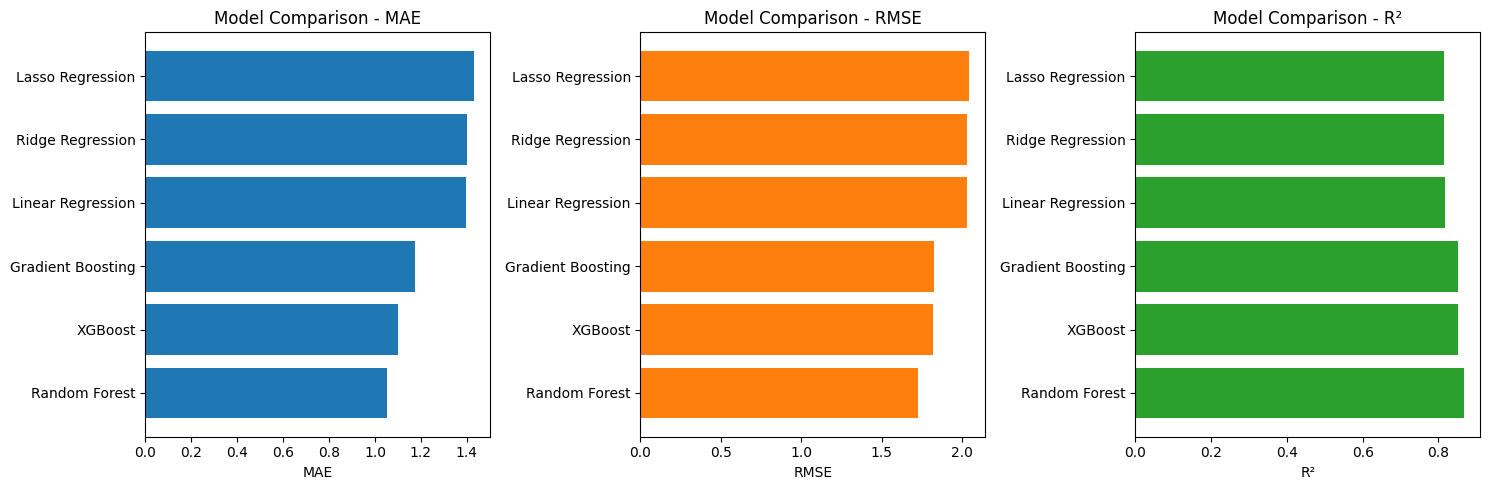

In [12]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, metric, color in zip(axes, ['MAE', 'RMSE', 'R²'], ['#1f77b4', '#ff7f0e', '#2ca02c']):
    data = results_df.sort_values(metric, ascending=(metric != 'R²'))
    ax.barh(data['Model'], data[metric], color=color)
    ax.set_xlabel(metric)
    ax.set_title(f'Model Comparison - {metric}')

plt.tight_layout()
plt.show()

## 7. Best Model Selection & Retrain

In [13]:
best_model_name = results_df.iloc[0]['Model']
print(f"Best Model: {best_model_name}")
print(f"  R²: {results_df.iloc[0]['R²']:.4f}")
print(f"  MAE: {results_df.iloc[0]['MAE']:.4f}")

Best Model: Random Forest
  R²: 0.8665
  MAE: 1.0511


In [14]:
# Retrain best model on full training data
X_full = df_2023[FEATURE_COLS].values
y_full = df_2023['score_target'].values

scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_full)

if best_model_name == 'Random Forest':
    best_model = RandomForestRegressor(n_estimators=100, random_state=42)
    best_model.fit(X_full, y_full)
    use_scaled = False
else:
    best_model = models[best_model_name]
    best_model.fit(X_full_scaled, y_full)
    use_scaled = True

print(f"Retrained {best_model_name} on {len(df_2023)} samples")

Retrained Random Forest on 2602 samples


## 8. Prediction on 2024 (Test Set)

In [15]:
print("Building features for target_year=2024...")
print("Features: 2020-2023 → Predict: 2024")
print()

df_2024 = build_training_features(
    pretrain, schools, provinces, summaries,
    target_year=2024, radius_km=500
)

print(f"\nBuilt {len(df_2024)} samples")

Building features for target_year=2024...
Features: 2020-2023 → Predict: 2024


Built 2602 samples


In [16]:
# Predict
X_test = df_2024[FEATURE_COLS].values
if use_scaled:
    X_test = scaler_full.transform(X_test)

predictions = best_model.predict(X_test)

# Create results
df_results = df_2024[['school_code', 'major_code', 'major_name', 'score_target']].copy()
df_results.columns = ['school_code', 'major_code', 'major_name', 'actual']
df_results['predicted'] = predictions
df_results['error'] = df_results['predicted'] - df_results['actual']
df_results['abs_error'] = df_results['error'].abs()

df_results.head(10)

,school_code,major_code,major_name,actual,predicted,error,abs_error
0,BMU,7720101,Y khoa,24.00,22.427700,-1.572300,1.572300
1,BMU,7720201,Dược học,21.00,20.950297,-0.049703,0.049703
2,BVH,7320104,Truyền thông đa phương tiện,25.94,26.626600,0.686600,0.686600
3,BVH,7329001,Công nghệ đa phương tiện,25.75,26.053200,0.303200,0.303200
4,BVH,7340101,Quản trị kinh doanh,25.17,24.563500,-0.606500,0.606500
5,BVH,7340115,Marketing,25.85,25.920500,0.070500,0.070500
6,BVH,7340122,Thương mại điện tử,26.09,27.271800,1.181800,1.181800
7,BVH,7340301,Kế toán,25.29,24.335800,-0.954200,0.954200
8,BVH,7480201,Công nghệ thông tin,26.40,28.017100,1.617100,1.617100
9,BVH,7480202,An toàn thông tin,25.85,26.381100,0.531100,0.531100


## 9. Evaluation on Test Set (2024)

In [17]:
# Calculate metrics
mae = df_results['abs_error'].mean()
rmse = np.sqrt((df_results['error'] ** 2).mean())
ss_res = ((df_results['actual'] - df_results['predicted']) ** 2).sum()
ss_tot = ((df_results['actual'] - df_results['actual'].mean()) ** 2).sum()
r2 = 1 - (ss_res / ss_tot)

print("Test Set Metrics (2024):")
print(f"  MAE:  {mae:.4f} điểm")
print(f"  RMSE: {rmse:.4f} điểm")
print(f"  R²:   {r2:.4f}")

Test Set Metrics (2024):
  MAE:  1.5863 điểm
  RMSE: 2.2000 điểm
  R²:   0.7973


In [18]:
# Error distribution
print("Error Distribution:")
print(f"  ≤ 0.5 điểm: {(df_results['abs_error'] <= 0.5).sum()} ({(df_results['abs_error'] <= 0.5).mean()*100:.1f}%)")
print(f"  ≤ 1.0 điểm: {(df_results['abs_error'] <= 1.0).sum()} ({(df_results['abs_error'] <= 1.0).mean()*100:.1f}%)")
print(f"  ≤ 2.0 điểm: {(df_results['abs_error'] <= 2.0).sum()} ({(df_results['abs_error'] <= 2.0).mean()*100:.1f}%)")
print(f"  > 5.0 điểm: {(df_results['abs_error'] > 5.0).sum()} ({(df_results['abs_error'] > 5.0).mean()*100:.1f}%)")

Error Distribution:
  ≤ 0.5 điểm: 668 (25.7%)
  ≤ 1.0 điểm: 1206 (46.3%)
  ≤ 2.0 điểm: 1857 (71.4%)
  > 5.0 điểm: 98 (3.8%)


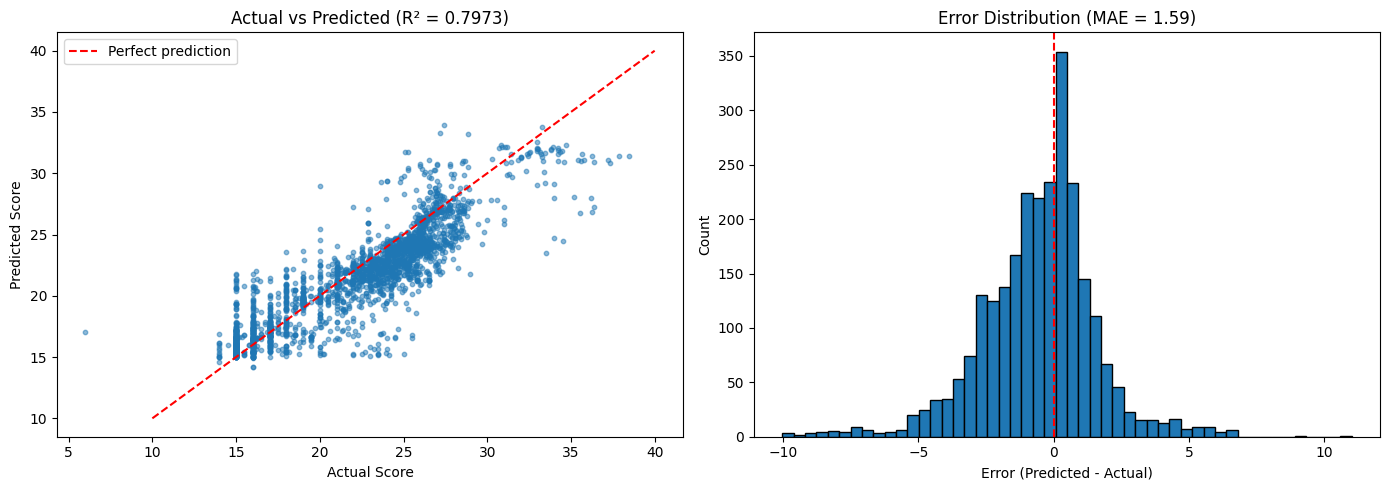

In [19]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
ax1 = axes[0]
ax1.scatter(df_results['actual'], df_results['predicted'], alpha=0.5, s=10)
ax1.plot([10, 40], [10, 40], 'r--', label='Perfect prediction')
ax1.set_xlabel('Actual Score')
ax1.set_ylabel('Predicted Score')
ax1.set_title(f'Actual vs Predicted (R² = {r2:.4f})')
ax1.legend()

# Histogram
ax2 = axes[1]
ax2.hist(df_results['error'], bins=50, edgecolor='black')
ax2.axvline(x=0, color='r', linestyle='--')
ax2.set_xlabel('Error (Predicted - Actual)')
ax2.set_ylabel('Count')
ax2.set_title(f'Error Distribution (MAE = {mae:.2f})')

plt.tight_layout()
plt.show()

In [20]:
# Top 10 worst predictions
print("Top 10 Worst Predictions:")
df_results.nlargest(10, 'abs_error')[['school_code', 'major_name', 'actual', 'predicted', 'error']]

Top 10 Worst Predictions:


,school_code,major_name,actual,predicted,error
541,DNC,Kiến trúc,6.00,17.013000,11.013000
1791,QSQ,Ngôn ngữ Anh,34.50,24.469300,-10.030700
2286,THP,Sư phạm Tiếng Anh,33.50,23.522200,-9.977800
184,DCV,Quản trị khách sạn,25.00,15.232833,-9.767167
1229,KHA,Thống kê kinh tế,36.23,26.845400,-9.384600
1609,QHT,Toán học,34.00,24.731700,-9.268300
1243,KHA,Hệ thống thông tin quản lý,36.36,27.210100,-9.149900
2369,TQU,Quản trị dịch vụ du lịch và lữ hành,24.15,15.145000,-9.005000
550,DNT,Ngôn ngữ Anh,20.00,28.949850,8.949850
1148,HTN,Công tác xã hội,25.50,16.562100,-8.937900


## 10. Save Results (Optional)

In [ ]:
# Uncomment to save results
# # df_results.to_csv('../data/predictions_2024.csv', index=False, encoding='utf-8-sig')
# # print("Saved predictions_2024.csv")

## 11. Summary

### Model Performance

| Metric | Validation (2023) | Test (2024) |
|--------|-------------------|-------------|
| Best Model | Random Forest | Random Forest |
| R² | ~0.87 | ~0.80 |
| MAE | ~1.05 điểm | ~1.59 điểm |

### Key Features (13 total)

1. **Score features (6)**: `score_prev_year`, `score_2year_ago`, `score_3year_ago`, `score_4year_ago`, `score_trend`, `avg_score_3year`
2. **Ratio features (5)**: `ratio_prev_year`, `ratio_2year_ago`, `ratio_3year_ago`, `ratio_4year_ago`, `ratio_trend`
3. **Weighted ratio (2)**: `weighted_ratio`, `weighted_ratio_score`

### Conclusions

- **~71%** dự đoán có sai số ≤ 2 điểm
- **~46%** dự đoán có sai số ≤ 1 điểm
- Feature `weighted_ratio_score` giúp điều chỉnh theo độ khó đề thi